# Lecture 7
Excercises proposed for the exams: Q1 and Q3

## Q1: The stock market

(This is about numba)

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Markov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probability that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 

In [1]:
import random

In [2]:
def chain(state, s_counts, N):
    """Evolve the initial stock-market state"""
    for i in range(N):
        p = random.uniform(0, 1)
        if(state==0):
            if(p>0.9 and p<0.975):
                state = 1
            if(p>0.975):
                state = 2
        else:
            if(state==1):
                if(p>0.8 and p<0.95):
                    state = 0
                if(p>0.95):
                    state = 2
            else:
                if(state==2):
                    if(p>0.5 and p<0.75):
                        state = 0
                    if(p>0.75):
                        state = 1
    
        s_counts[state] += 1
    for i in range(len(s_counts)):
            s_counts[i] /= N

In [3]:
states = [0, 1, 2] #bull, bear, stagnant
s_counts = [0., 0., 0.]

state = random.randint(0, 2)

N = 10000000

In [4]:
from numba import njit
numba_chain = njit(chain)

In [5]:
s_counts = [0., 0., 0.]
numba_chain(state, s_counts, 10) # To compile it once

In [6]:
s_counts = [0., 0., 0.]
%timeit chain(state, s_counts, N)

1.4 s ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
s_counts = [0., 0., 0.]
%timeit numba_chain(state, s_counts, N)

58.8 ms ± 75 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
print(s_counts)

[0.6249040625290662, 0.31282133121096317, 0.062274706259980626]


## Q3: Scaling

(This is about multiprocessing)

The ["scaling"](https://hpc-wiki.info/hpc/Scaling) of a code refers to its performance of as a function of the number of cores adopted. 

- Define a computationally intensive task (something like an operation on two giant arrays with >1e7 numbers or, even better!, pick somethinbg from your research). 
- Make sure it's embarrassingly parallel. 
- Implement a parallelization strategy using multiprocessing. 
- Plot the time the code takes as a function of the number of cores.
- Figure out the number of cores in your CPU and make sure the plot extends both below and above this number.
- Interpret the resulting features. 
- A perfect scaling results in straight line (linear dependency). How perfect is your scaling?

In [9]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import struct
import multiprocessing, pathos.multiprocessing
from tqdm.notebook import tqdm
import os
import time

In [13]:
def get_wf_integral(wf, int_low, int_up):
    """ Integrate a waveform in a given window [int_low;int_up]"""
    integral = np.sum(wf[int_low:int_up])
    return integral

def read_channel(channel_file):
    """Read a binary file with little endian ordering"""
    with open(channel_file, "rb") as file:
        binary_data = file.read()
        uint16_data = struct.unpack('<' + 'H' * (len(binary_data) // 2), binary_data)
        y = np.array(uint16_data)
        ticks = 4096
        wfs = y.reshape(len(y)//ticks, ticks).astype(float)
    for wf in wfs:
        baseline = (np.sum(wf[0:835]))/835.
        wf -= baseline 
    return -wfs

def build_template(wfs):
    """Average all the waveforms and send t -> -t for the matched filter"""
    n = 0.
    avg = np.zeros(4096).astype(float)
    for wf in wfs:
        avg += wf
        n += 1
    n = 1/n
    avg = avg*n
    template = np.flip(avg)
    return template

def build_calib_spectrum(wfs, template, int_low, int_up):
    """Create the calibration spectrum (integral distribution) for filtered waveforms"""
    int_wf = np.empty(shape=(0,)).astype(float)
    for wf in wfs:
        filtered_wf = signal.convolve(wf, template)
        int_wf = np.append(int_wf, get_wf_integral(filtered_wf, int_low, int_up))
    return int_wf

In [14]:
ch_file = "channel_17.dat"

wfs = read_channel(ch_file)
template = build_template(wfs)

In [15]:
len(template)

4096

Text(0, 0.5, 'ADC counts')

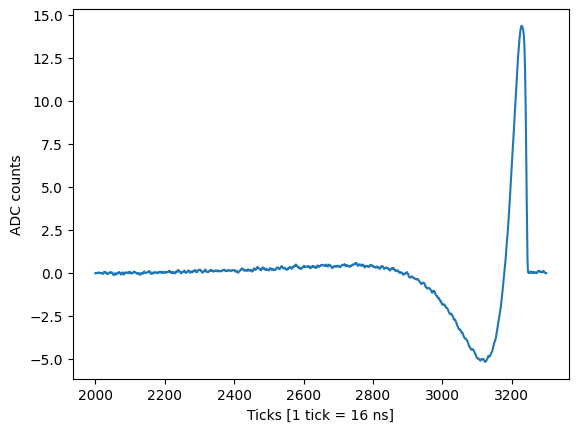

In [20]:
x = np.linspace(0, 4096, 4096, endpoint=False)
plt.plot(x[2000:3300], template[2000:3300])
plt.xlabel('Ticks [1 tick = 16 ns]')
plt.ylabel('ADC counts')

Text(0, 0.5, 'ADC counts')

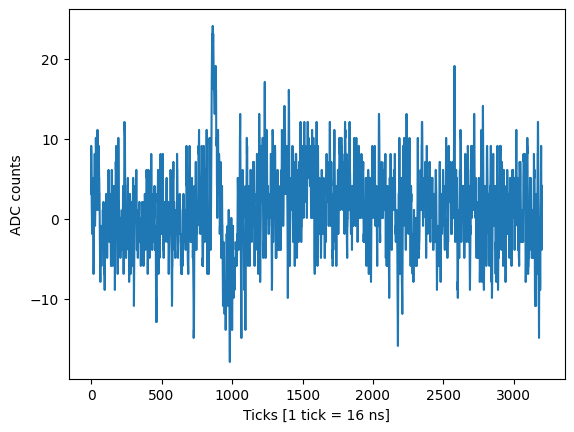

In [21]:
filtered_wf = signal.convolve(wfs[4], template[2000:3300])

x = np.linspace(0, 10000, 10000, endpoint=False)
plt.plot(x[0:3200], wfs[2][0:3200]) # How a raw wavewform looks like
plt.xlabel('Ticks [1 tick = 16 ns]')
plt.ylabel('ADC counts')

In [18]:
def avg_wf(wfs, template):
    n = 0.
    avg = np.zeros(4096+len(template)-1).astype(float)
    for wf in wfs:
        avg += signal.convolve(wf, template)
        n += 1
    n = 1/n
    avg = avg*n
    return avg

avg = avg_wf(wfs, template)

[229.82905360303863, 360.17094639696137]


Text(0, 0.5, 'ADC counts')

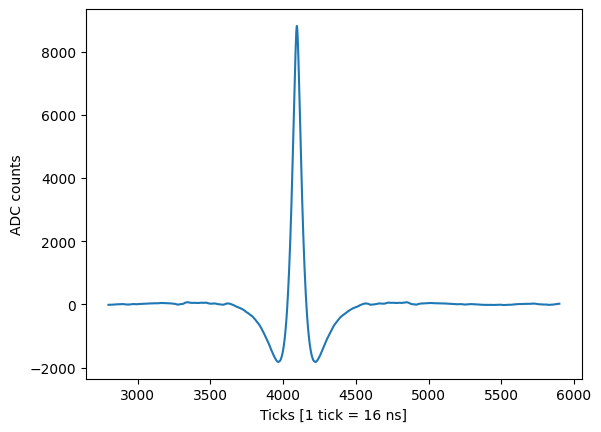

In [33]:
def zero_crossings(arr):
    # Find sign changes
    signs = np.sign(arr)
    zero_crossings_indices = np.where(np.diff(signs))[0]
    
    # Interpolate zero-crossings
    zero_crossings_points = []
    for idx in zero_crossings_indices:
        if signs[idx] == 0:  # Handle exactly zero points
            zero_crossings_points.append(idx)
        else:
            # Linear interpolation between adjacent points
            x1, x2 = idx, idx + 1
            y1, y2 = arr[x1], arr[x2]
            zero_crossings_points.append(x1 - y1 * (x2 - x1) / (y2 - y1))
    
    return zero_crossings_points

zc_points = zero_crossings(avg[3800:4400])

print(zc_points)

plt.plot(x[2800:5900], avg[2800:5900]) # How the average filtered waveform looks like
plt.xlabel('Ticks [1 tick = 16 ns]')
plt.ylabel('ADC counts')

In [23]:
%%time
int_wf = build_calib_spectrum(wfs, template, 3800+270, 3800+320)

CPU times: user 1.23 s, sys: 108 ms, total: 1.34 s
Wall time: 1.35 s


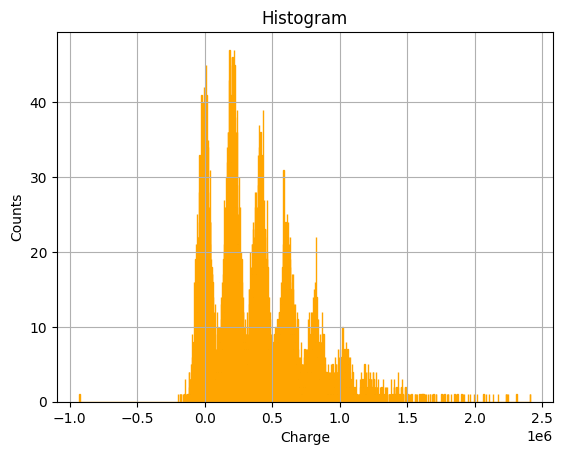

In [24]:
plt.hist(int_wf, bins=2000, edgecolor='orange')
plt.title('Histogram')
plt.xlabel('Charge')
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [26]:
arguments = [wfs[0:500], template, 3800+230, 3800+360]
list = [arguments for _ in range(30)]


#def build_calib_spectrum(wfs, template, int_low, int_up):
def build_calib_spectrum(arguments):
    from scipy import signal
    int_wf = np.empty(shape=(0,)).astype(float)
    for wf in arguments[0]:
        filtered_wf = signal.convolve(wf, arguments[1])
        int_wf = np.append(int_wf, get_wf_integral(filtered_wf, arguments[2], arguments[3]))
    return int_wf

In [27]:
%%time
int_wf = np.fromiter( map(build_calib_spectrum, list),  dtype=np.ndarray)

CPU times: user 1.76 s, sys: 15.4 ms, total: 1.78 s
Wall time: 1.79 s


In [28]:
multiprocessing.cpu_count()

8

In [29]:
CPUS = 8
parmap = pathos.multiprocessing.ProcessingPool(CPUS).imap

In [30]:
%%time 
int_wf = np.fromiter( parmap(build_calib_spectrum, list),  dtype=np.ndarray)

CPU times: user 59.6 ms, sys: 124 ms, total: 184 ms
Wall time: 531 ms


In [31]:
import time
t_CPU = np.empty(shape=(0,)).astype(float)

for cpu in tqdm(range(12)):
    parmap = pathos.multiprocessing.ProcessingPool(cpu+1).imap # I can't set cpu=0
    t0 = time.time()
    int_wf = np.fromiter( parmap(build_calib_spectrum, list),  dtype=np.ndarray)
    t1 = time.time()
    t_CPU = np.append(t_CPU, t1-t0)

t_CPU

  0%|          | 0/12 [00:00<?, ?it/s]

array([2.23073602, 1.16699696, 0.8362782 , 0.6676507 , 0.59242606,
       0.58111906, 0.58741999, 0.54755998, 0.55982399, 0.5732851 ,
       0.59131384, 0.575243  ])

Text(0, 0.5, 'Total time [s]')

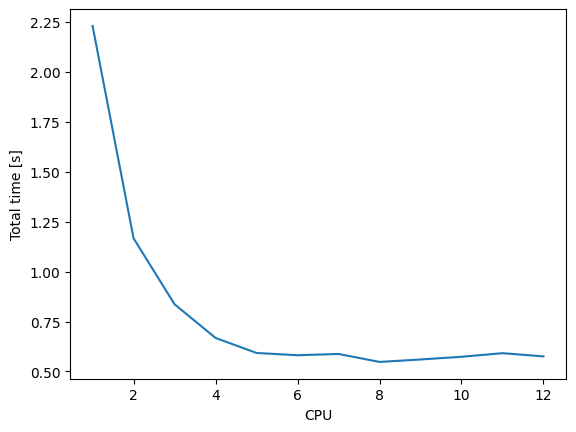

In [32]:
plt.plot(x[0:len(t_CPU)]+1, t_CPU)
plt.xlabel('CPU')
plt.ylabel('Total time [s]')

Comments:
- 2 cpus basically half the time
- We appreciate the improvement up to 5 cpu, then it saturates
- As expected, we don't have any speed up above the 8 cpu (my laptop has just 8 of them)
- The task I implemented is really dumb (it repeat the very same calibration n-times) but it useful to run calibration in parallel. I didn't wanted to upload Gb of data.